In [57]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os, json
from pathlib import Path
import datetime
from datetime import datetime as dt

warnings.filterwarnings("ignore")

import os
output_folder = Path("data/daily")
output_hotstocks = Path("output/hotstocks") 
output_hotscore = Path("output/hotscore")
output_volumespike = Path("output/volumespike")
output_momentum = Path("output/momentum")

os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_hotstocks, exist_ok=True)
os.makedirs(output_hotscore, exist_ok=True)
os.makedirs(output_volumespike, exist_ok=True)
os.makedirs(output_momentum, exist_ok=True)

# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")

def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [ ]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})

print("Downloading lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 58
Most Active: 31
Trending: 19
Total unique hot symbols: 94


In [ ]:
def fix_num(x):
    """
    Convert formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)
    
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

top50 = output_df.head(50)

timestamp = dt.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50


🔥 Saved TOP 50 hot stocks to: data\daily\hot_stocks_20251126155957.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
4,ADSK,314.9900,6.982984,988119.0,1483401.0,6.739039e+10,0.666117,0.950617,0.975309,0.987654,0.938272,0.965432
0,URBN,77.4061,13.315913,2710962.0,2098090.0,6.943165e+09,1.292109,1.000000,0.987654,0.938272,0.802469,0.963580
7,SYM,82.2200,6.374039,1183419.0,2168859.0,4.873939e+10,0.545641,0.913580,0.962963,0.827160,0.827160,0.904938
1,MESO,17.4800,8.841844,115964.0,242231.0,2.250476e+09,0.478733,0.987654,0.938272,0.641975,0.864198,0.888889
15,NBIX,151.8300,5.782765,313833.0,941981.0,1.513832e+10,0.333163,0.864198,0.864198,0.913580,0.925926,0.880247
2,ARWR,50.8200,8.612948,720973.0,2311350.0,7.026249e+09,0.311927,0.975309,0.839506,0.802469,0.753086,0.870988
5,HOOD,122.7200,6.186727,10625482.0,35537503.0,1.103485e+11,0.298993,0.901235,0.814815,0.901235,0.456790,0.826543
21,ASML,1046.7100,4.335040,387176.0,1564801.0,4.062780e+11,0.247428,0.728395,0.753086,1.000000,1.000000,0.818519
3,FLNC,18.1500,8.228974,2556276.0,7608900.0,3.315343e+09,0.335959,0.962963,0.876543,0.617284,0.382716,0.805556
13,KSS,23.5949,5.240411,3283846.0,6160917.0,2.644391e+09,0.533013,0.814815,0.950617,0.592593,0.481481,0.784568


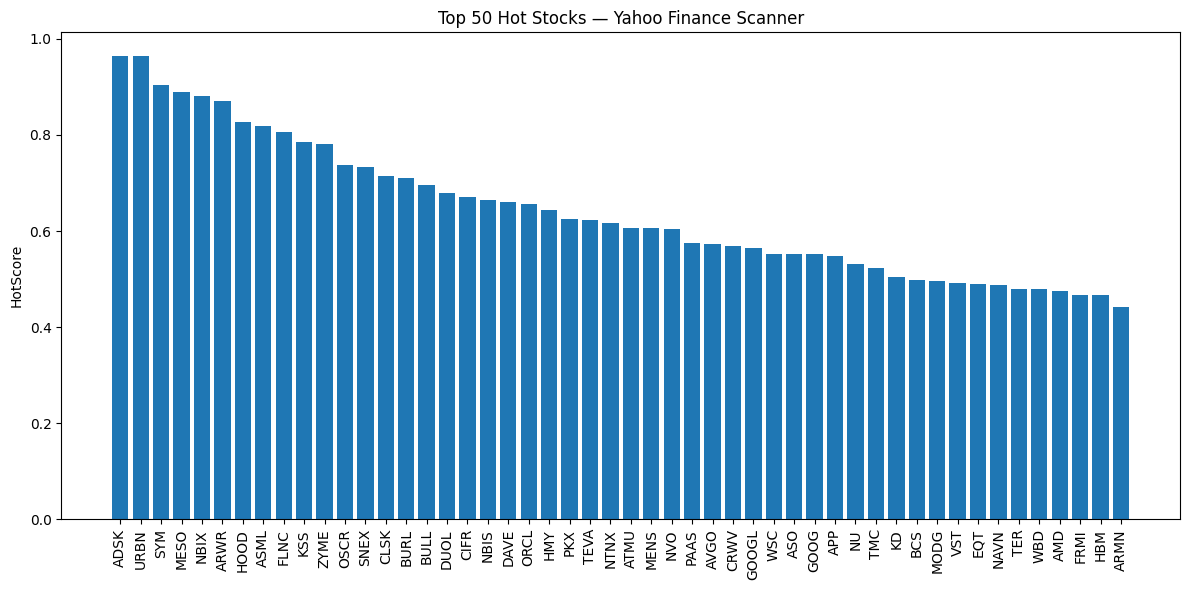


📊 Saved HOT STOCKS chart to: output\hotstocks\hot_stocks_20251126155957.png


In [ ]:

timestamp = dt.now().strftime("%Y%m%d%H%M%S") 
move_file = output_hotstocks / f"hot_stocks_{timestamp}.png"

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.savefig(move_file)
plt.show()
plt.close()
print("\n📊 Saved HOT STOCKS chart to:", move_file)

In [61]:

try:
    top50  # DataFrame with columns including symbol, HotScore, regularMarketPrice, regularMarketChangePercent, regularMarketVolume, VolumeSpike
except NameError:
    raise RuntimeError("Expected DataFrame 'top50' not found. Rename your top50 var or adapt this block.")

# configuration
today = datetime.date.today()
date_str = today.strftime("%Y%m%d") 
timestamp = dt.now().strftime("%Y%m%d%H%M%S")

DATA_DAILY = Path("data/daily")
ML_FOLDER = Path("ml")

for p in ( DATA_DAILY, ML_FOLDER):
    p.mkdir(parents=True, exist_ok=True)

# 1) Save top50 CSV
top50_file = DATA_DAILY / f"hot_stocks_{timestamp}.csv"   # keep full timestamp for uniqueness
top50.to_csv(top50_file, index=False)
print("Saved:", top50_file)


# 2) Heatmap of HotScore (symbols x 1 day) -> very small heatmap but useful in dashboard
# We'll produce a horizontal heatmap (symbols on y)
heatmap_file = output_hotscore / f"heatmap_hotscore_{timestamp}.png"
plt.figure(figsize=(10, max(4, 0.18*len(top50))))
# prepare matrix: each symbol a single value -> use imshow
vals = top50["HotScore"].values.reshape((-1,1))
plt.imshow(vals, aspect='auto', cmap='YlOrRd')
plt.yticks(range(len(top50)), top50["symbol"])
plt.xticks([])
plt.colorbar(label='HotScore')
plt.title(f"HotScore - Top50 - {date_str}")
plt.tight_layout()
plt.savefig(heatmap_file, dpi=200)
plt.close()
print("Saved:", heatmap_file)

# 3) Volume spike bar chart (top50)
vol_file = output_volumespike / f"volume_spike_{timestamp}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["VolumeSpike"])
plt.xticks(rotation=90)
plt.title(f"Volume Spike — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(vol_file, dpi=200)
plt.close()
print("Saved:", vol_file)

# 4) Momentum bar chart (daily percent change)
mom_file = output_momentum / f"momentum_percent_{timestamp}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["regularMarketChangePercent"])
plt.xticks(rotation=90)
plt.title(f"Momentum (% change today) — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(mom_file, dpi=200)
plt.close()
print("Saved:", mom_file)



Saved: data\daily\hot_stocks_20251126155959.csv
Saved: output\hotscore\heatmap_hotscore_20251126155959.png
Saved: output\volumespike\volume_spike_20251126155959.png
Saved: output\momentum\momentum_percent_20251126155959.png
Saved: output\hourly\daily_report_20251126155959.html
Saved: data\daily\metadata_daily_20251126.json
Saved: ml\features_20251126.csv

Daily outputs completed. Files saved to 'output/ and 'data/.
